In [1]:
import pandas as pd
import numpy as np
from bcb import sgs
from bcb import currency
from datetime import date
from fredapi import Fred
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from scipy.optimize import curve_fit
from sklearn import linear_model

In [2]:
api_key = '5beeb88b7a5cdd7d4fd8b976e138b52e'
fred = Fred(api_key = api_key)

<AxesSubplot:xlabel='Date'>

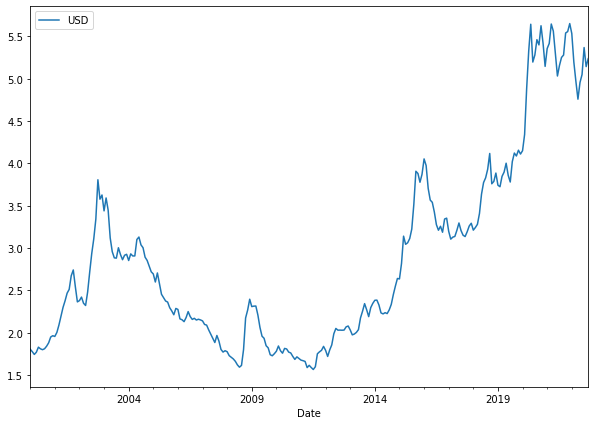

In [3]:
cy = currency.get('USD', start='2000-01-01',end = str(date.today()))
cy = cy.resample('m').mean()
cy = cy.iloc[:-3]
cy.plot(figsize = (10, 7))

In [4]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pyGRNN import GRNN
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from xgboost import XGBRegressor

In [12]:
def get_indicators(start_date):
    selic = sgs.get(('SELIC',432),start = start_date)
    ipca = sgs.get(('IPCA',13522),start = start_date)
    emprego = sgs.get(('emprego',28763),start = start_date)
    pib_crescimento = sgs.get(('PIB',1208),start = start_date)
    gdp_eua = fred.get_series(series_id = 'GDPC1',observation_start = start_date)
    cpi = fred.get_series(series_id = 'USACPIALLMINMEI',observation_start = f'{int(start_date[:4]) - 1}{start_date[4:]}')
    inflacion_rate = pd.Series(data = (cpi.values[12:] - cpi.values[:-12]) / cpi.values[:-12],index = cpi.iloc[12:].index)
    employment = fred.get_series(series_id = 'CE16OV',observation_start = start_date)
    interest = fred.get_series(series_id = 'INTDSRUSM193N',observation_start = start_date)
    dataframe = emprego.copy()
    dataframe['emprego'] = dataframe['emprego'] / 100000000
    dataframe['PIB'] = pib_crescimento / 1000000000000
    dataframe['PIB'] = dataframe['PIB'].fillna(method = 'ffill') / 10
    dataframe['SELIC'] = selic['SELIC'] / 100
    dataframe['IPCA'] = ipca['IPCA'] / 100
    dataframe['PIB_EUA'] = gdp_eua
    dataframe['PIB_EUA'] = dataframe['PIB_EUA'].fillna(method = 'ffill') / 100000
    dataframe['CPI'] = inflacion_rate * 10
    dataframe['employment'] = employment / 1000000
    dataframe['interest_rates'] = interest
    dataframe['interest_rates'] = dataframe['interest_rates'].fillna(method = 'ffill') / 10
    return dataframe

def train_test_split(xdata,ydata,horizonte):
    meses = horizonte * 12
    y_train,y_test = ydata.values[:-meses],ydata.values[-meses:]
    x_train,x_test = xdata.values[-meses - len(y_train):-meses],xdata.values[-meses:]
    return x_train,y_train.ravel(),x_test,y_test.ravel()

def time_features_split(serie,anos,time = False):
    data = serie.copy()
    data['mes'] = data.index.month
    data['quarter'] = data.index.quarter
    features = ['mes','quarter']
    if time:
        data['tempo'] = list(range(len(data)))
        features.append('tempo')
    x_temp_train = data[features].iloc[:-anos * 12].values
    x_temp_test = data[features].iloc[-anos * 12:].values
    return x_temp_train,x_temp_test

def untrend(serie,window):
    data = pd.DataFrame({'y':serie})
    data['mavg'] = data['y'].rolling(window,center = True).mean()
    data['mavg'] = data['mavg'].fillna(method = 'ffill')
    data['mavg'] = data['mavg'].fillna(method = 'bfill')
    data['no_trend'] = data['y'] - data['mavg']
    return data['no_trend'].values

def square(x,a,b,c):
    return ((x ** 2) * a) + (x * b) + c

def simple_square(x,a):
    return (x ** 2) * a

def linear(x,a,b):
    return (x * a) + b

class base_model:
    def __init__(self,data,func):
        self.data = data
        self.func = func
    def fit(self):
        y = self.data
        self.popt = curve_fit(self.func,list(range(len(y))),y)[0]
        self.x0 = len(y)
        self.last_y = y[-1]
        return self
    def predict(self,n):
        prediction = np.array([self.func(x,*self.popt) for x in range(self.x0,self.x0 + n)])
        diferenca = prediction[0] - self.last_y
        return prediction - diferenca

class modelo:
    def __init__(self,name,ydata,xdata = None):
        self.name = name
        if name == 'holt':
            self.model = ExponentialSmoothing(ydata,seasonal_periods = 12,trend = "add",seasonal = "add").fit(0,0,0)
        if name == 'arima':
            self.model = AutoARIMA(sp = 12,suppress_warnings = True).fit(ydata)
        if self.name == 'grnn':
            self.model = GRNN().fit(xdata,ydata)

    def predict(self,n = None,data = None):
        if self.name == 'holt':
            return self.model.forecast(n)
        if self.name == 'arima':
            return self.model.predict(fh = list(range(1,n + 1))).ravel()
        if self.name == 'grnn':
            return self.model.predict(data)

class GodModel:
    def __init__(self,func,modelo,peso = 0.5):
        self.peso = peso
        self.func = func
        self.name = modelo
    
    def fit(self,target_data,extra_data,time_features = None):
        # Regressão linear das features secundarias
        self.reg = linear_model.LinearRegression()
        self.reg.fit(extra_data,target_data)
        # Regressão polinomial no tempo
        self.x0 = len(target_data)
        self.features = range(len(extra_data[0]))
        self.popts = [curve_fit(square,list(range(self.x0)),extra_data[:,i])[0] for i in self.features]
        self.popts_main = curve_fit(self.func,list(range(self.x0)),target_data)[0]
        # Sazonalidade
        untrended = untrend(target_data,12)
        self.model = modelo(self.name,untrended,time_features)
        self.target_data = target_data
        self.extra_data = extra_data
        return self

    def predict(self,n,time_features = None):
        self.predictions = []
        for i in self.features:
            popt = self.popts[i]
            prediction = np.array([square(x,*popt) for x in range(self.x0,self.x0 + n)])
            partial_last_year_mean = self.extra_data[-12:,i].mean()
            diferenca = partial_last_year_mean - prediction[0]
            prediction = prediction + diferenca
            self.predictions.append(prediction)
        main_prediction = np.array([self.func(x,*self.popts_main) for x in range(self.x0,self.x0 + n)])
        predictores = np.array(self.predictions).T
        feat_prediction = self.reg.predict(predictores)
        trend = (main_prediction * self.peso) + (feat_prediction * (1 - self.peso))
        seasonality = self.model.predict(n,time_features)
        prediction_final = trend + seasonality
        # Ajustes finais
        last_year_mean = self.target_data[-12:].mean()
        diferenca = last_year_mean - prediction_final[0]
        prediction_final = prediction_final + diferenca
        micro_diferenca = self.target_data[-1] - prediction_final[0]
        prediction_final = np.array([prediction_final[i] + (micro_diferenca * (1 - (i / (len(prediction_final) - 1)))) for i in range(len(prediction_final))])
        return prediction_final

In [6]:
df = get_indicators('2000-01-01')
df = df.iloc[:-1]

MSE: 0.04776199094815051
RMSE: 0.21854516912563066


<AxesSubplot:xlabel='Date'>

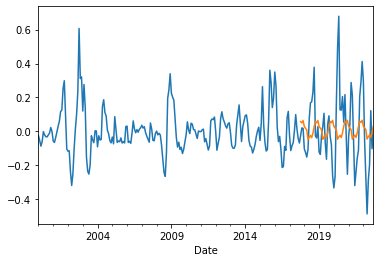

In [8]:
anos = 5
data = cy.copy()
data['no_trend'] = untrend(data['USD'].values,12)
train,test = data.iloc[:-anos * 12]['no_trend'].values,data.iloc[-anos * 12:]['no_trend'].values
model = ExponentialSmoothing(train,seasonal_periods = 12,trend = "add",seasonal = "add").fit(0,0,0)
prediction = model.forecast(anos * 12)
data['pred'] = [None for _ in range(len(data) - (anos * 12))] + list(prediction)
print('MSE:',mean_squared_error(prediction,test))
print('RMSE:',rmse(prediction,test))
data['no_trend'].plot()
data['pred'].plot()

Executing warm start...
Warm start concluded. The optimum isotropic sigma is [1.64502503]
Gradient search concluded. The optimum sigma is [1.64501242 1.6449885 ]
MSE: 0.04678261942243162
RMSE: 0.21629290192336784


<AxesSubplot:xlabel='Date'>

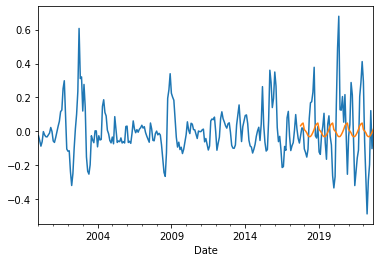

In [9]:
anos = 5
data = cy.copy()
data['no_trend'] = untrend(data['USD'].values,12)
x_train,x_test = time_features_split(data,anos)
y_train,y_test = data['no_trend'].iloc[:-anos * 12].values,data['no_trend'].iloc[-anos * 12:].values
model = GRNN().fit(x_train,y_train)
prediction = model.predict(x_test)
print('MSE:',mean_squared_error(prediction,y_test))
print('RMSE:',rmse(prediction,y_test))
data['pred'] = [None for _ in range(len(data) - (anos * 12))] + list(prediction)
data['no_trend'].plot()
data['pred'].plot()

MSE: 0.050949248012544315
RMSE: 0.22571940105481478


<AxesSubplot:xlabel='Date'>

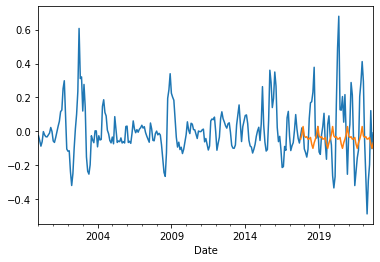

In [10]:
anos = 5
data = cy.copy()
data['no_trend'] = untrend(data['USD'].values,12)
x_train,x_test = time_features_split(data,anos,True)
y_train,y_test = data['no_trend'].iloc[:-anos * 12].values,data['no_trend'].iloc[-anos * 12:].values
model = XGBRegressor().fit(x_train,y_train)
prediction = model.predict(x_test)
print('MSE:',mean_squared_error(prediction,y_test))
print('RMSE:',rmse(prediction,y_test))
data['pred'] = [None for _ in range(len(data) - (anos * 12))] + list(prediction)
data['no_trend'].plot()
data['pred'].plot()

MSE: 0.04634171109343065
RMSE: 0.21527125003917882


<AxesSubplot:xlabel='Date'>

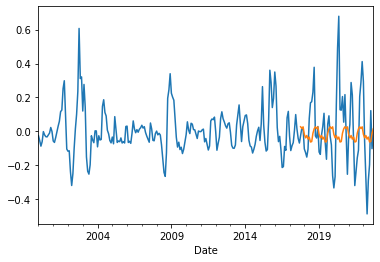

In [11]:
anos = 5
data = cy.copy()
data['no_trend'] = untrend(data['USD'].values,12)
train,test = data.iloc[:-anos * 12]['no_trend'].values,data.iloc[-anos * 12:]['no_trend'].values
forecaster = TBATS(use_box_cox=False,use_trend=False,use_damped_trend=False,sp=12,use_arma_errors=False)
forecaster.fit(data['no_trend'].values)
prediction = forecaster.predict(fh = [i for i in range(1,(anos * 12) + 1)]).ravel()
print('MSE:',mean_squared_error(prediction,test))
print('RMSE:',rmse(prediction,test))
data['pred'] = [None for _ in range(len(data) - (anos * 12))] + list(prediction)
data['no_trend'].plot()
data['pred'].plot()

MSE: 0.046695775635459305
RMSE: 0.2160920536147947


<AxesSubplot:xlabel='Date'>

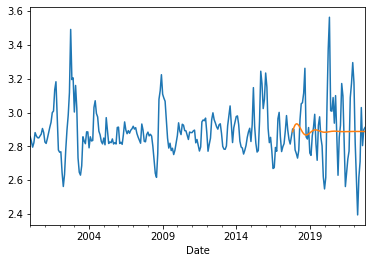

In [14]:
anos = 5
data = cy.copy()
data['no_trend'] = untrend(data['USD'].values,12)
train,test = data.iloc[:-anos * 12]['no_trend'].values,data.iloc[-anos * 12:]['no_trend'].values
forecaster = AutoARIMA(sp = 12,suppress_warnings = True,stationary = True)
forecaster.fit(train)
prediction = forecaster.predict(fh = [i for i in range(1,(anos * 12) + 1)]).ravel()
print('MSE:',mean_squared_error(prediction,test))
print('RMSE:',rmse(prediction,test))
data['pred'] = [None for _ in range(len(data) - (anos * 12))] + list(prediction)
data['no_trend'].plot()
data['pred'].plot()

MSE: 0.18970706807858326
RMSE: 0.43555374878260805


<AxesSubplot:xlabel='Date'>

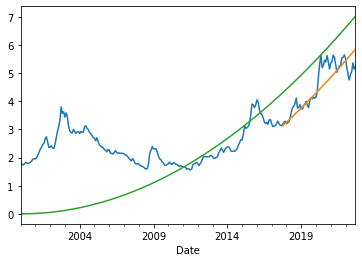

In [15]:
anos = 5
func = simple_square
x_train,y_train,x_test,y_test = train_test_split(df,cy,anos)
model = base_model(y_train,func).fit()
prediction = model.predict(12 * anos)
print('MSE:',mean_squared_error(prediction,y_test))
print('RMSE:',rmse(prediction,y_test))
pred_df = cy.copy()
pred_df['prediction'] = [None for _ in range(len(pred_df) - len(prediction))] + list(prediction.ravel())
pred_df['curve'] = [func(x,*model.popt) for x in range(len(pred_df))]
pred_df['USD'].plot()
pred_df['prediction'].plot()
pred_df['curve'].plot()

MSE: 0.1967967615826386
RMSE: 0.44361781026311214


<AxesSubplot:xlabel='Date'>

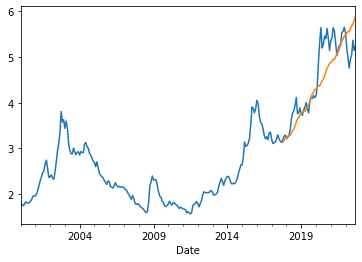

In [11]:
anos = 5
x_train,y_train,x_test,y_test = train_test_split(df,cy,anos)
model = GodModel(simple_square,'holt',1).fit(y_train,x_train)
prediction = model.predict(12 * anos)
print('MSE:',mean_squared_error(prediction,y_test))
print('RMSE:',rmse(prediction,y_test))
pred_df = cy.copy()
pred_df['prediction'] = [None for _ in range(len(pred_df) - len(prediction))] + list(prediction.ravel())
pred_df['USD'].plot()
pred_df['prediction'].plot()

MSE: 0.2809224018818885
RMSE: 0.5300211334294969


<AxesSubplot:xlabel='Date'>

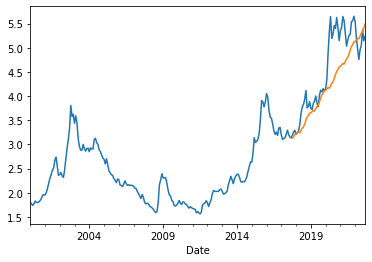

In [16]:
anos = 5
x_train,y_train,x_test,y_test = train_test_split(df,cy,anos)
model = GodModel(simple_square,'holt',0.7).fit(y_train,x_train)
prediction = model.predict(12 * anos)
print('MSE:',mean_squared_error(prediction,y_test))
print('RMSE:',rmse(prediction,y_test))
pred_df = cy.copy()
pred_df['prediction'] = [None for _ in range(len(pred_df) - len(prediction))] + list(prediction.ravel())
pred_df['USD'].plot()
pred_df['prediction'].plot()

Executing warm start...
Warm start concluded. The optimum isotropic sigma is [1.65372239]
Gradient search concluded. The optimum sigma is [1.65401247 1.65398822]
MSE: 0.3983511835074724
RMSE: 0.6311506820938027


<AxesSubplot:xlabel='Date'>

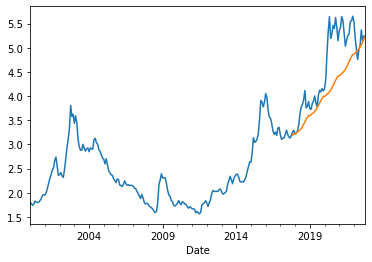

In [19]:
anos = 5
data = cy.copy()
x_train,y_train,x_test,y_test = train_test_split(df,cy,anos)
x_temp_train,x_temp_test = time_features_split(data,anos)
model = GodModel(simple_square,'grnn',0.5).fit(y_train,x_train,x_temp_train)
prediction = model.predict(12 * anos,x_temp_test)
print('MSE:',mean_squared_error(prediction,y_test))
print('RMSE:',rmse(prediction,y_test))
pred_df = cy.copy()
pred_df['prediction'] = [None for _ in range(len(pred_df) - len(prediction))] + list(prediction.ravel())
pred_df['USD'].plot()
pred_df['prediction'].plot()

<AxesSubplot:>

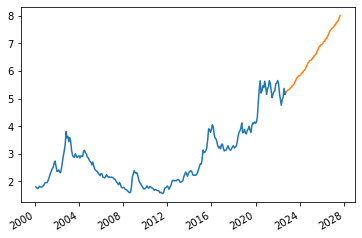

In [42]:
x_train,y_train = df.values,cy.values.ravel()
model = GodModel(simple_square,'holt',0.5).fit(y_train,x_train)
prediction = model.predict(12 * 5)
pred_df = cy.copy()
pred_df['prediction'] = None
new_df = pd.DataFrame({'prediction':prediction,'USD':None},index = pd.date_range(start = pred_df.index[-1],freq = 'M',periods = 12 * 5))
pred_df = pd.concat([pred_df,new_df])
pred_df['USD'].plot()
pred_df['prediction'].plot()